# BT4012 Fraud Analytics Project – Enhanced Baseline Notebook

This notebook implements an improved fraud detection pipeline for the BT4012 group project.

It is structured to align with the recommended report flow:

1. Data Loading & Understanding  
2. Exploratory Data Analysis (EDA) - in a separate notebook
3. Feature Engineering  
4. Data Preprocessing & Handling Class Imbalance  
5. Model Training with Cross-Validation  
6. Model Comparison  
7. Feature Importance & Business Insights  

> **Datasets used:** `loan_applications.csv`, `transactions.csv`

## Imports and Configs

In [1]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- MODIFIED ---
from sklearn.model_selection import (
    StratifiedKFold, train_test_split, 
    RandomizedSearchCV, GridSearchCV
)
from scipy.stats import uniform, randint
# --- END MODIFICATION ---

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    classification_report, precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional tree boosting models
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None
    print("xgboost not installed – XGBClassifier will be skipped.")

try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None
    print("lightgbm not installed – LGBMClassifier will be skipped.")

# Display settings
pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

## Load Datasets

In [2]:
data_dir = "."

loan_path = os.path.join(data_dir, "loan_applications.csv")
txn_path = os.path.join(data_dir, "transactions.csv")

loan_df = pd.read_csv(loan_path)
txn_df = pd.read_csv(txn_path)

loan_rows = loan_df.shape[0]
txn_rows = txn_df.shape[0]
print("Number of rows in Loan Applications dataset:", loan_rows)
print("Number of rows in Transactions dataset:", txn_rows)

display(loan_df.head())
display(txn_df.head())

Number of rows in Loan Applications dataset: 50000
Number of rows in Transactions dataset: 50000


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,3.17,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.00,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,31.08,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,13.89,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,2.51,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN


,transaction_id,customer_id,transaction_date,transaction_type,transaction_amount,merchant_category,merchant_name,transaction_location,account_balance_after_transaction,is_international_transaction,device_used,ip_address,transaction_status,transaction_source_destination,transaction_notes,fraud_flag
0,2d7ddfd4-1112-4354-a2dd-fad94b45a850,CUST102188,2022-01-04 11:27:00,Bill Payment,2100.0,Dining,"Rattan, Khanna and Magar","Srikakulam, Himachal Pradesh",8211.0,0,Web,31.102.21.141,Success,BCHG80012468703731,Payment for Dining,0
1,ba998721-a612-4e0a-8354-46d001e9c39c,CUST107144,2022-01-03 23:52:00,UPI,1400.0,Travel,Chauhan LLC,"Giridih, Manipur",12858.0,0,Web,176.48.222.166,Success,CJPZ11841095072972,Payment for Travel,0
2,0b4ad8e2-40ac-49c9-b59a-c9efaaccc7a6,CUST102126,2022-01-15 06:54:00,Debit Card,1000.0,Entertainment,Halder-Sarma,"Avadi, Kerala",19268.0,0,ATM,181.62.105.161,Success,TLCG50761416960179,Payment for Entertainment,0
3,c4fce988-34c5-48db-8686-bfad0b3bc0b5,CUST109887,2022-01-08 07:57:00,Credit Card,10500.0,Utilities,"Anand, Khare and Balakrishnan","Navi Mumbai, Maharashtra",29585.0,0,ATM,121.157.246.80,Success,PRZJ55096553432036,Payment for Utilities,0
4,f9b8ca30-00e5-4322-8cff-eac0554cf2da,CUST108620,2022-01-02 10:43:00,Loan Disbursement,8100.0,Electronics,Zacharia and Sons,"Visakhapatnam, Gujarat",0.0,0,ATM,129.96.5.57,Success,NBAI29021393288369,Payment for Electronics,0


## Feature Engineering - Transactions

In [6]:
# Convert transaction_date to datetime
txn_df["transaction_date"] = pd.to_datetime(txn_df["transaction_date"], errors="coerce")

# Sort by customer & time
txn_df = txn_df.sort_values(["customer_id", "transaction_date"])

# --- Create new time/behavioral features on the raw transaction log ---

# Calculate transaction frequency for each customer over different time windows
txn_df['txn_day'] = txn_df['transaction_date'].dt.day
txn_df['txn_week'] = txn_df['transaction_date'].dt.isocalendar().week
txn_df['txn_month'] = txn_df['transaction_date'].dt.month

# Calculate time since last transaction
# This will be aggregated to 'mean_time_between_txns' etc.
txn_df['txn_time_diff'] = txn_df.groupby('customer_id')['transaction_date'].diff().dt.total_seconds()

# Hour of the day
txn_df['txn_hour'] = txn_df['transaction_date'].dt.hour

# Calculate rolling mean and standard deviation for transaction amounts over a 7-day window
# Note: .rolling(7) means 7 *rows* (transactions), not 7 days.
# A true 7-day window is more complex. We'll aggregate the row-based rolling features.
txn_df['txn_amount_rolling_mean_7txn'] = txn_df.groupby('customer_id')['transaction_amount'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
txn_df['txn_amount_rolling_std_7txn'] = txn_df.groupby('customer_id')['transaction_amount'].rolling(7, min_periods=1).std().reset_index(0, drop=True)

# Identifying outliers (e.g., 95th percentile transactions)
txn_df['txn_amount_outlier'] = txn_df['transaction_amount'] > txn_df['transaction_amount'].quantile(0.95)

In [7]:
# 4.1 Basic numeric aggregations per customer
txn_amount_agg = txn_df.groupby("customer_id")["transaction_amount"].agg(
    ["sum", "mean", "max", "min", "std", "count"]
).rename(
    columns={
        "sum": "txn_amount_sum",
        "mean": "txn_amount_mean",
        "max": "txn_amount_max",
        "min": "txn_amount_min",
        "std": "txn_amount_std",
        "count": "txn_count",
    }
)
txn_amount_agg["txn_amount_std"] = txn_amount_agg["txn_amount_std"].fillna(0)


# 4.2 Transaction type counts per customer
txn_type_counts = (
    txn_df
    .pivot_table(
        index="customer_id",
        columns="transaction_type",
        values="transaction_id",
        aggfunc="count",
        fill_value=0,
    )
)
txn_type_counts.columns = [f"txn_type_{c}_count" for c in txn_type_counts.columns]


# 4.3 Merchant category counts per customer
merchant_cat_counts = (
    txn_df
    .pivot_table(
        index="customer_id",
        columns="merchant_category",
        values="transaction_id",
        aggfunc="count",
        fill_value=0,
    )
)
merchant_cat_counts.columns = [f"merchant_cat_{c}_count" for c in merchant_cat_counts.columns]


# 4.4 --- NEW: Aggregate the time-based features ---
time_based_features = txn_df.groupby('customer_id').agg(
    # Time between transactions
    mean_time_between_txn_sec=('txn_time_diff', 'mean'),
    std_time_between_txn_sec=('txn_time_diff', 'std'),
    max_time_between_txn_sec=('txn_time_diff', 'max'),
    
    # Time of day
    mean_txn_hour=('txn_hour', 'mean'),
    std_txn_hour=('txn_hour', 'std'),
    
    # Rolling features (we take the mean of the rolling values)
    mean_rolling_amt_7txn=('txn_amount_rolling_mean_7txn', 'mean'),
    mean_rolling_std_7txn=('txn_amount_rolling_std_7txn', 'mean'),
    
    # Outliers
    num_outlier_txns=('txn_amount_outlier', 'sum'),
    
    # Transaction recency (how long ago was their *last* transaction?)
    # This requires a reference "today" date
    # last_txn_date=('transaction_date', 'max')
)
# Note: For recency, you would need to calculate (today - last_txn_date).
# We will skip it for now as it adds complexity, but it's a good idea.


# --- Combine all transaction-level features ---
all_txn_aggs = [
    txn_amount_agg,
    txn_type_counts,
    merchant_cat_counts,
    time_based_features # Add the new features
]

txn_features = pd.concat(all_txn_aggs, axis=1)

print("Engineered transaction feature shape:", txn_features.shape)
display(txn_features.head())

Engineered transaction feature shape: (18318, 36)


,txn_amount_sum,txn_amount_mean,txn_amount_max,txn_amount_min,txn_amount_std,txn_count,txn_type_ATM Withdrawal_count,txn_type_Bill Payment_count,txn_type_Credit Card_count,txn_type_Debit Card_count,txn_type_Deposit_count,txn_type_EMI Payment_count,txn_type_Fund Transfer_count,txn_type_Loan Disbursement_count,txn_type_Net Banking_count,txn_type_UPI_count,merchant_cat_Cash Withdrawal_count,merchant_cat_Dining_count,merchant_cat_Education_count,merchant_cat_Electronics_count,merchant_cat_Entertainment_count,merchant_cat_Financial Services_count,merchant_cat_Fuel_count,merchant_cat_Groceries_count,merchant_cat_Healthcare_count,merchant_cat_Online Shopping_count,merchant_cat_Travel_count,merchant_cat_Utilities_count,mean_time_between_txn_sec,std_time_between_txn_sec,max_time_between_txn_sec,mean_txn_hour,std_txn_hour,mean_rolling_amt_7txn,mean_rolling_std_7txn,num_outlier_txns
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CUST100000,2700.0,1350.000000,2500.0,200.0,1626.345597,2,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,417360.0,NaN,417360.0,17.000000,2.828427,775.000000,1626.345597,0
CUST100001,23200.0,7733.333333,15200.0,1400.0,6969.457176,3,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,905670.0,6.801377e+05,1386600.0,18.000000,1.000000,4377.777778,5323.206219,1
CUST100003,13200.0,4400.000000,10100.0,1200.0,4948.737213,3,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1043910.0,1.047890e+06,1784880.0,10.333333,6.110101,2616.666667,2721.855980,0
CUST100005,14700.0,7350.000000,10500.0,4200.0,4454.772721,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,231180.0,NaN,231180.0,7.000000,5.656854,5775.000000,4454.772721,0
CUST100006,7600.0,2533.333333,4500.0,200.0,2173.323108,3,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,1,747090.0,5.334272e+05,1124280.0,12.666667,3.785939,1694.444444,2606.941134,0


## Feature Engineering – Loan Applications

In [8]:
loan_fe_df = loan_df.copy()

# Convert application_date to datetime
loan_fe_df["application_date"] = pd.to_datetime(loan_fe_df["application_date"], errors="coerce")

# Numeric ratios – standard in credit/fraud scoring
loan_fe_df["loan_to_income_ratio"] = loan_fe_df["loan_amount_requested"] / (loan_fe_df["monthly_income"] + 1e-9)
loan_fe_df["debt_to_income_ratio"] = loan_fe_df["existing_emis_monthly"] / (loan_fe_df["monthly_income"] + 1e-9)

# Simple age buckets (could be useful for non-linear effects)
loan_fe_df["age_bucket"] = pd.cut(
    loan_fe_df["applicant_age"],
    bins=[0, 25, 35, 45, 60, 100],
    labels=["<=25", "26-35", "36-45", "46-60", "60+"],
    include_lowest=True,
)

# You can optionally extract a coarse "region" from residential_address.
# Here we use the last token after the final comma as a proxy.
def extract_region(addr):
    if isinstance(addr, str) and "," in addr:
        return addr.split(",")[-1].strip()
    return "Unknown"

loan_fe_df["region"] = loan_fe_df["residential_address"].apply(extract_region)

display(loan_fe_df[[
    "application_id", "customer_id", "loan_amount_requested",
    "monthly_income", "loan_to_income_ratio", "debt_to_income_ratio",
    "applicant_age", "age_bucket", "region"
]].head())

,application_id,customer_id,loan_amount_requested,monthly_income,loan_to_income_ratio,debt_to_income_ratio,applicant_age,age_bucket,region
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,604000.0,34700.0,17.406340,0.031700,28,26-35,918055
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,100000.0,51600.0,1.937984,0.000000,44,36-45,909564
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,431000.0,14800.0,29.121622,0.310811,56,46-60,797564
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,324000.0,28800.0,11.250000,0.138889,27,26-35,097184
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,100000.0,43900.0,2.277904,0.025057,50,46-60,775386


## Merge Loan & Transaction Features

In [9]:
# Index transaction features by customer_id for merging
txn_features_reset = txn_features.reset_index()

# Left-join: keep all loan applications
full_df = loan_fe_df.merge(
    txn_features_reset,
    on="customer_id",
    how="left",
)

print("Full merged dataset shape:", full_df.shape)
display(full_df.head())

# Check missingness of engineered transaction features
txn_feature_cols = [c for c in full_df.columns if c.startswith(("txn_", "merchant_cat_"))]
print("\nMissingness in transaction-derived features:")
display(full_df[txn_feature_cols].isna().mean().sort_values(ascending=False).head(10))

Full merged dataset shape: (50000, 60)


,application_id,customer_id,application_date,loan_type,loan_amount_requested,loan_tenure_months,interest_rate_offered,purpose_of_loan,employment_status,monthly_income,cibil_score,existing_emis_monthly,debt_to_income_ratio,property_ownership_status,residential_address,applicant_age,gender,number_of_dependents,loan_status,fraud_flag,fraud_type,loan_to_income_ratio,age_bucket,region,txn_amount_sum,txn_amount_mean,txn_amount_max,txn_amount_min,txn_amount_std,txn_count,txn_type_ATM Withdrawal_count,txn_type_Bill Payment_count,txn_type_Credit Card_count,txn_type_Debit Card_count,txn_type_Deposit_count,txn_type_EMI Payment_count,txn_type_Fund Transfer_count,txn_type_Loan Disbursement_count,txn_type_Net Banking_count,txn_type_UPI_count,merchant_cat_Cash Withdrawal_count,merchant_cat_Dining_count,merchant_cat_Education_count,merchant_cat_Electronics_count,merchant_cat_Entertainment_count,merchant_cat_Financial Services_count,merchant_cat_Fuel_count,merchant_cat_Groceries_count,merchant_cat_Healthcare_count,merchant_cat_Online Shopping_count,merchant_cat_Travel_count,merchant_cat_Utilities_count,mean_time_between_txn_sec,std_time_between_txn_sec,max_time_between_txn_sec,mean_txn_hour,std_txn_hour,mean_rolling_amt_7txn,mean_rolling_std_7txn,num_outlier_txns
0,c8bf0bea-70e6-4870-9125-41b8210c527f,CUST109427,2023-04-09,Business Loan,604000.0,12,11.66,Medical Emergency,Retired,34700.0,714,1100.0,0.031700,Rented,"94/31, Sehgal Zila, Vadodara-380521, Anantapur...",28,Female,3,Approved,0,NaN,17.406340,26-35,918055,13700.0,6850.000000,8800.0,4900.0,2757.716447,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,352140.0,NaN,352140.0,11.00,1.414214,5875.000000,2757.716447,0.0
1,91224cec-3544-4bc7-ac15-a9792da54c02,CUST106146,2023-09-23,Car Loan,100000.0,240,13.62,Education,Unemployed,51600.0,667,0.0,0.000000,Owned,"H.No. 00, Sheth Chowk, Ichalkaranji 006728, Im...",44,Other,3,Approved,0,NaN,1.937984,36-45,909564,18700.0,4675.000000,9800.0,900.0,3730.393187,4.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,615140.0,296614.369847,787020.0,14.50,9.327379,4010.416667,2043.339302,0.0
2,4efcd02d-4a03-4ab7-9bd1-0ff430493d0c,CUST100674,2023-05-22,Education Loan,431000.0,60,11.40,Medical Emergency,Self-Employed,14800.0,808,4600.0,0.310811,Rented,"H.No. 81, Dutta Path, Kozhikode-340301, Tadepa...",56,Other,4,Approved,0,NaN,29.121622,46-60,797564,13100.0,3275.000000,7600.0,300.0,3607.746296,4.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,634540.0,951735.146141,1732440.0,19.75,5.852350,4672.916667,3069.304867,0.0
3,a61337d4-ba04-4a68-b492-2cb8266e6ed7,CUST106466,2024-07-09,Car Loan,324000.0,120,10.36,Debt Consolidation,Self-Employed,28800.0,647,4000.0,0.138889,Rented,"H.No. 022, Rege Road, Tiruvottiyur-927857, Aur...",27,Other,4,Declined,0,NaN,11.250000,26-35,097184,2900.0,1450.000000,2200.0,700.0,1060.660172,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1597800.0,NaN,1597800.0,12.00,8.485281,1825.000000,1060.660172,0.0
4,a8d1639e-170b-41b2-826a-55c7dae38d16,CUST112319,2023-11-20,Personal Loan,100000.0,36,14.14,Business Expansion,Salaried,43900.0,624,1100.0,0.025057,Rented,"85/24, Bali Zila, Sambalpur 922071, Tumkur, Ke...",50,Other,0,Declined,0,NaN,2.277904,46-60,775386,35600.0,11866.666667,18500.0,3300.0,7782.244749,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,63600.0,26643.783515,82440.0,14.00,7.000000,11405.555556,7603.432976,1.0



Missingness in transaction-derived features:


txn_amount_sum                           0.08406
txn_amount_mean                          0.08406
merchant_cat_Travel_count                0.08406
merchant_cat_Online Shopping_count       0.08406
merchant_cat_Healthcare_count            0.08406
merchant_cat_Groceries_count             0.08406
merchant_cat_Fuel_count                  0.08406
merchant_cat_Financial Services_count    0.08406
merchant_cat_Entertainment_count         0.08406
merchant_cat_Electronics_count           0.08406
dtype: float64

## Preprocessing & Class Imabalance Handling

In [10]:
# Target
y = full_df["fraud_flag"].astype(int)

# Columns to drop
drop_cols = [
    "fraud_flag",
    "fraud_type",
    "application_id",
    "customer_id",
    "residential_address",
    "application_date",
    "loan_status",
    "region"
]

X = full_df.drop(columns=[c for c in drop_cols if c in full_df.columns])

# Identify numeric & categorical columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric features:", len(numeric_cols))
print("Categorical features:", len(categorical_cols))

# --- Imputation before pipeline ---
txn_prefixes = ("txn_", "merchant_cat_", "mean_", "std_", "max_", "num_")
for col in numeric_cols:
    if col.startswith(txn_prefixes):
        X[col] = X[col].fillna(0)

# Class imbalance – compute positive weight
counter = Counter(y)
neg, pos = counter[0], counter[1]
print("\nClass distribution:", counter)
if pos > 0:
    scale_pos_weight = neg / pos
else:
    scale_pos_weight = 1.0
print("scale_pos_weight (for XGB/LGBM):", scale_pos_weight)

# --- MODIFIED: Define CV strategy here ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
# --- END MODIFICATION ---

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

Numeric features: 46
Categorical features: 6

Class distribution: Counter({0: 48974, 1: 1026})
scale_pos_weight (for XGB/LGBM): 47.732943469785575


## Train/Val Split (Baseline)

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train size:", X_train.shape, "Valid size:", X_valid.shape)

# Baseline logistic regression with class_weight
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg),
])

log_reg_clf.fit(X_train, y_train)
y_valid_proba = log_reg_clf.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_proba >= 0.5).astype(int)

print("\nBaseline Logistic Regression (hold-out)")
print("AUC:", roc_auc_score(y_valid, y_valid_proba))
print("Precision:", precision_score(y_valid, y_valid_pred, zero_division=0))
print("Recall:", recall_score(y_valid, y_valid_pred, zero_division=0))
print("F1:", f1_score(y_valid, y_valid_pred, zero_division=0))

Train size: (40000, 52) Valid size: (10000, 52)

Baseline Logistic Regression (hold-out)
AUC: 0.6200042331204323
Precision: 0.03071287686672302
Recall: 0.5317073170731708
F1: 0.0580713905167821


## Hyperparameter Tuning

In [12]:
# --- NEW CELL: Hyperparameter Tuning ---
# Purpose: Find the best hyperparameters for our models using RandomizedSearchCV
# We will use the X_train, y_train split from Cell 9 for this.
# The `skf` and `preprocessor` variables are from Cell 8.

print("Starting hyperparameter tuning...")

# --- 1. Logistic Regression (GridSearch is fast) ---
print("Tuning LogisticRegression...")
log_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1))
])
log_reg_params = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'saga']
}
log_reg_search = GridSearchCV(log_reg_pipe, log_reg_params, cv=skf, scoring='f1', n_jobs=1)
log_reg_search.fit(X_train, y_train) 
print(f"LogReg Best F1: {log_reg_search.best_score_:.4f}")
print(f"LogReg Best Params: {log_reg_search.best_params_}\n")


# --- 2. Random Forest (RandomizedSearch) ---
print("Tuning RandomForest...")
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1))
])
rf_params = {
    'model__n_estimators': randint(100, 400),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 11),
    'model__min_samples_leaf': randint(1, 5),
    'model__max_features': ['sqrt', 'log2', 0.5]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_params, n_iter=10, cv=skf, scoring='f1', n_jobs=1, random_state=RANDOM_STATE)
rf_search.fit(X_train, y_train)
print(f"RF Best F1: {rf_search.best_score_:.4f}")
print(f"RF Best Params: {rf_search.best_params_}\n")


# --- 3. XGBoost (RandomizedSearch) ---
if XGBClassifier is not None:
    print("Tuning XGBoost...")
    xgb_pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(scale_pos_weight=scale_pos_weight, objective="binary:logistic", eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=1))
    ])
    xgb_params = {
        'model__n_estimators': randint(100, 600),
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': randint(3, 8),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.7, 0.3)
    }
    xgb_search = RandomizedSearchCV(xgb_pipe, xgb_params, n_iter=10, cv=skf, scoring='f1', n_jobs=1, random_state=RANDOM_STATE)
    xgb_search.fit(X_train, y_train)
    print(f"XGB Best F1: {xgb_search.best_score_:.4f}")
    print(f"XGB Best Params: {xgb_search.best_params_}\n")
else:
    print("XGBoost not available, skipping tuning.")

print("--- Tuning Complete ---")

# --- Store the best parameters automatically ---
best_model_params = {
    "LogisticRegression": {k.split('__')[1]: v for k, v in log_reg_search.best_params_.items()},
    "RandomForest": {k.split('__')[1]: v for k, v in rf_search.best_params_.items()}
}
if XGBClassifier is not None:
    best_model_params["XGBoost"] = {k.split('__')[1]: v for k, v in xgb_search.best_params_.items()}

print("\nBest parameters have been saved to 'best_model_params' dictionary:")
print(best_model_params)

Starting hyperparameter tuning...
Tuning LogisticRegression...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

LogReg Best F1: 0.0606
LogReg Best Params: {'model__C': 0.1, 'model__solver': 'liblinear'}

Tuning RandomForest...
RF Best F1: 0.4561
RF Best Params: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 6, 'model__n_estimators': 199}

Tuning XGBoost...
XGB Best F1: 0.7084
XGB Best Params: {'model__colsample_bytree': np.float64(0.7692681476866446), 'model__learning_rate': np.float64(0.05820509320520235), 'model__max_depth': 6, 'model__n_estimators': 554, 'model__subsample': np.float64(0.8829989973347863)}

--- Tuning Complete ---

Best parameters have been saved to 'best_model_params' dictionary:
{'LogisticRegression': {'C': 0.1, 'solver': 'liblinear'}, 'RandomForest': {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 199}, 'XGBoost': {'colsample_bytree': np.float64(0.7692681476866446), 'learning_rate': np.float64(0.05820509320520235), 'max_depth': 6, 'n_estimators': 554, 'subsa

## CV & Model Comparison

In [13]:
# --- MODIFIED: This cell now uses the `best_model_params` dictionary ---
# The 'models' dictionary is now built *dynamically*.

models = {}

# Logistic Regression
models["LogisticRegression"] = LogisticRegression(
    **best_model_params["LogisticRegression"], # Unpack the saved params
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# Random Forest
models["RandomForest"] = RandomForestClassifier(
    **best_model_params["RandomForest"], # Unpack the saved params
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# XGBoost (if available)
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(
        **best_model_params["XGBoost"], # Unpack the saved params
        scale_pos_weight=scale_pos_weight,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=1,
    )

# --- End of Modification ---

# The CV loop now runs using these new, tuned models.
# `skf` is already defined from Cell 8.

# --- Store OOF probabilities for each model ---
oof_predictions = {}

for model_name, base_clf in models.items():
    print(f"\n==== {model_name} ====")
    oof_proba = np.zeros(len(X), dtype=float) # Note: OOF is on FULL X, y

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Fold {fold}")
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = Pipeline(steps=[("preprocess", preprocessor), ("model", base_clf)])
        clf.fit(X_tr, y_tr)
        proba_val = clf.predict_proba(X_val)[:, 1]
        oof_proba[val_idx] = proba_val

    oof_predictions[model_name] = oof_proba

# --- Evaluate models by finding the BEST threshold for F1 ---
print("\nCross-validated model performance (OOF with Optimal Threshold):")
results = []

for model_name, proba in oof_predictions.items():
    auc = roc_auc_score(y, proba)
    precisions, recalls, thresholds = precision_recall_curve(y, proba)
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    best_precision = precisions[best_f1_idx]
    best_recall = recalls[best_f1_idx]

    results.append({
        "model": model_name,
        "auc": auc,
        "best_f1": best_f1,
        "best_threshold": best_threshold,
        "precision_at_best_f1": best_precision,
        "recall_at_best_f1": best_recall,
    })

results_df = pd.DataFrame(results).sort_values("best_f1", ascending=False)
display(results_df)

print("\nNOTE: Tuning was fast (n_iter=10). For your final report, you could try n_iter=50.")


==== LogisticRegression ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== RandomForest ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== XGBoost ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

Cross-validated model performance (OOF with Optimal Threshold):


,model,auc,best_f1,best_threshold,precision_at_best_f1,recall_at_best_f1
2,XGBoost,0.946604,0.818475,0.492073,0.911483,0.742690
1,RandomForest,0.950380,0.789616,0.335582,0.886999,0.711501
0,LogisticRegression,0.634879,0.085416,0.676006,0.055687,0.183236



NOTE: Tuning was fast (n_iter=10). For your final report, you could try n_iter=50.


In [14]:
models = {}

# Logistic Regression
models["LogisticRegression"] = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# Random Forest
models["RandomForest"] = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=1,
)

# XGBoost (if available)
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        n_jobs=1,
    )

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# --- Store OOF probabilities for each model ---
oof_predictions = {}

for model_name, base_clf in models.items():
    print(f"\n==== {model_name} ====")
    oof_proba = np.zeros(len(X), dtype=float)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"Fold {fold}")
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        clf = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", base_clf),
        ])
        clf.fit(X_tr, y_tr)
        proba_val = clf.predict_proba(X_val)[:, 1]
        oof_proba[val_idx] = proba_val

    # Store the full OOF probability array for this model
    oof_predictions[model_name] = oof_proba

# --- NEW: Evaluate models by finding the BEST threshold for F1 ---
print("\nCross-validated model performance (OOF with Optimal Threshold):")
results = []

for model_name, proba in oof_predictions.items():
    # Calculate AUC (threshold-independent)
    auc = roc_auc_score(y, proba)

    # Find the best threshold for F1 score
    precisions, recalls, thresholds = precision_recall_curve(y, proba)
    # Calculate F1 score for all thresholds
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)
    
    # Find the threshold that gives the best F1
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    # Get precision and recall at that best threshold
    best_precision = precisions[best_f1_idx]
    best_recall = recalls[best_f1_idx]

    results.append({
        "model": model_name,
        "auc": auc,
        "best_f1": best_f1,
        "best_threshold": best_threshold,
        "precision_at_best_f1": best_precision,
        "recall_at_best_f1": best_recall,
    })

results_df = pd.DataFrame(results).sort_values("best_f1", ascending=False)
display(results_df)

print("\nNOTE: The tree models (RF, XGB) still need hyperparameter tuning (e.g., RandomizedSearchCV)!")
print("These scores are with default/manual params, but now at least use an optimal threshold.")


==== LogisticRegression ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== RandomForest ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

==== XGBoost ====
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

Cross-validated model performance (OOF with Optimal Threshold):


,model,auc,best_f1,best_threshold,precision_at_best_f1,recall_at_best_f1
1,RandomForest,0.952276,0.787817,0.229265,0.822034,0.756335
2,XGBoost,0.919579,0.514497,0.648737,0.560276,0.475634
0,LogisticRegression,0.634541,0.085708,0.680419,0.056504,0.177388



NOTE: The tree models (RF, XGB) still need hyperparameter tuning (e.g., RandomizedSearchCV)!
These scores are with default/manual params, but now at least use an optimal threshold.


## Fit Final Model & Feature Importances

Best model identified: RandomForest
Training final RandomForest model on all data...
Training complete.

Top 20 most important features:


,feature,importance
3,monthly_income,0.057149
11,txn_amount_mean,0.047621
7,applicant_age,0.045410
12,txn_amount_max,0.044513
43,mean_rolling_amt_7txn,0.044439
10,txn_amount_sum,0.044335
41,mean_txn_hour,0.043878
13,txn_amount_min,0.035726
44,mean_rolling_std_7txn,0.033344
40,max_time_between_txn_sec,0.032799


/var/folders/nt/lksf3v5916q60xttk_z7182m0000gn/T/ipykernel_68802/1223869347.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


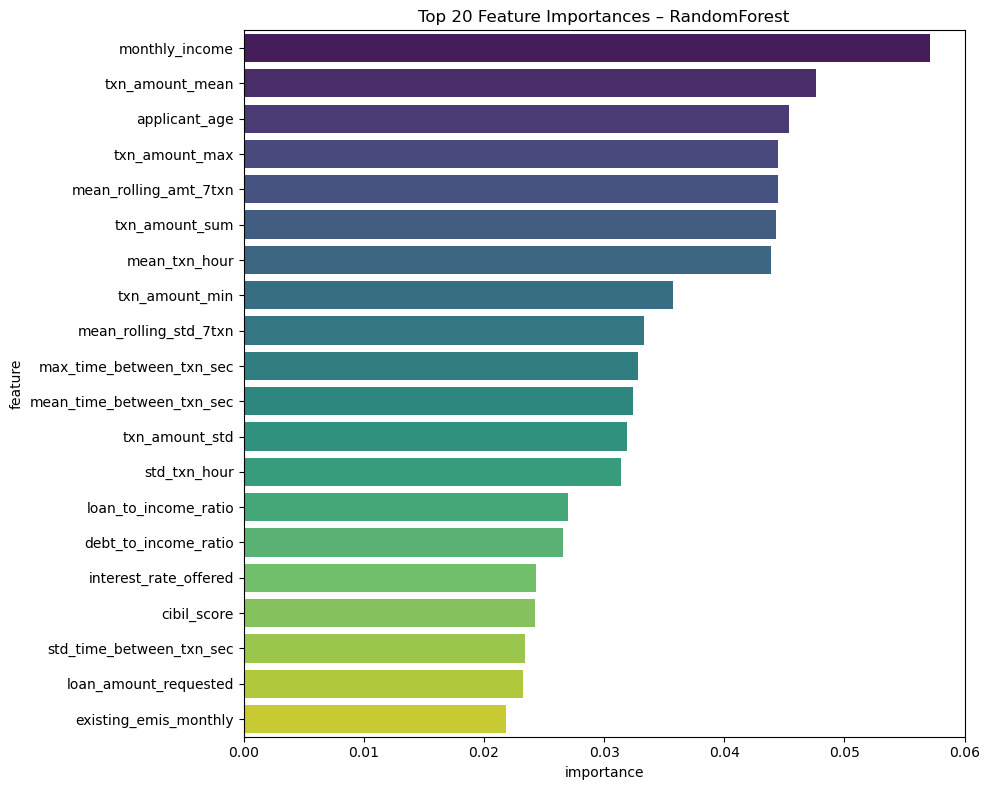

In [15]:
# Choose the best-performing model by F1/AUC from results_df
best_model_name = results_df.iloc[0]["model"]
print("Best model identified:", best_model_name)

final_base_clf = models[best_model_name]

final_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", final_base_clf),
])

print(f"Training final {best_model_name} model on all data...")
final_clf.fit(X, y)
print("Training complete.")

# Extract feature importances if the model supports it (tree-based models)
model_step = final_clf.named_steps["model"]

if hasattr(model_step, "feature_importances_"):
    # Get feature names after preprocessing
    preprocessor_fitted = final_clf.named_steps["preprocess"]

    num_features = numeric_cols
    cat_ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"]
    cat_features = cat_ohe.get_feature_names_out(categorical_cols)

    feature_names = np.concatenate([num_features, cat_features])
    importances = model_step.feature_importances_

    fi = pd.DataFrame({
        "feature": feature_names,
        "importance": importances,
    }).sort_values("importance", ascending=False)

    print("\nTop 20 most important features:")
    display(fi.head(20))

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x="importance",
        y="feature",
        data=fi.head(20),
        palette="viridis"
    )
    plt.title(f"Top 20 Feature Importances – {best_model_name}")
    plt.tight_layout()
    plt.show()
    
elif hasattr(model_step, "coef_"):
    # Handle Logistic Regression coefficients
    print("Model is Logistic Regression. Showing top 20 coefficients.")
    
    preprocessor_fitted = final_clf.named_steps["preprocess"]
    num_features = numeric_cols
    cat_ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["onehot"]
    cat_features = cat_ohe.get_feature_names_out(categorical_cols)
    feature_names = np.concatenate([num_features, cat_features])
    
    # Get the coefficients (it's a 2D array, [0] for binary class)
    coefficients = model_step.coef_[0]
    
    fi = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefficients,
        "abs_coefficient": np.abs(coefficients)
    }).sort_values("abs_coefficient", ascending=False)
    
    print("\nTop 20 most impactful features (by absolute coefficient):")
    display(fi.head(20))

    # Plot
    fi_plot = fi.head(20).sort_values("coefficient")
    plt.figure(figsize=(10, 8))
    sns.barplot(
        x="coefficient",
        y="feature",
        data=fi_plot,
        palette="vlag"
    )
    plt.title(f"Top 20 Feature Coefficients – {best_model_name}")
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Model {best_model_name} does not expose feature_importances_ or coef_.")

## Plotting Results

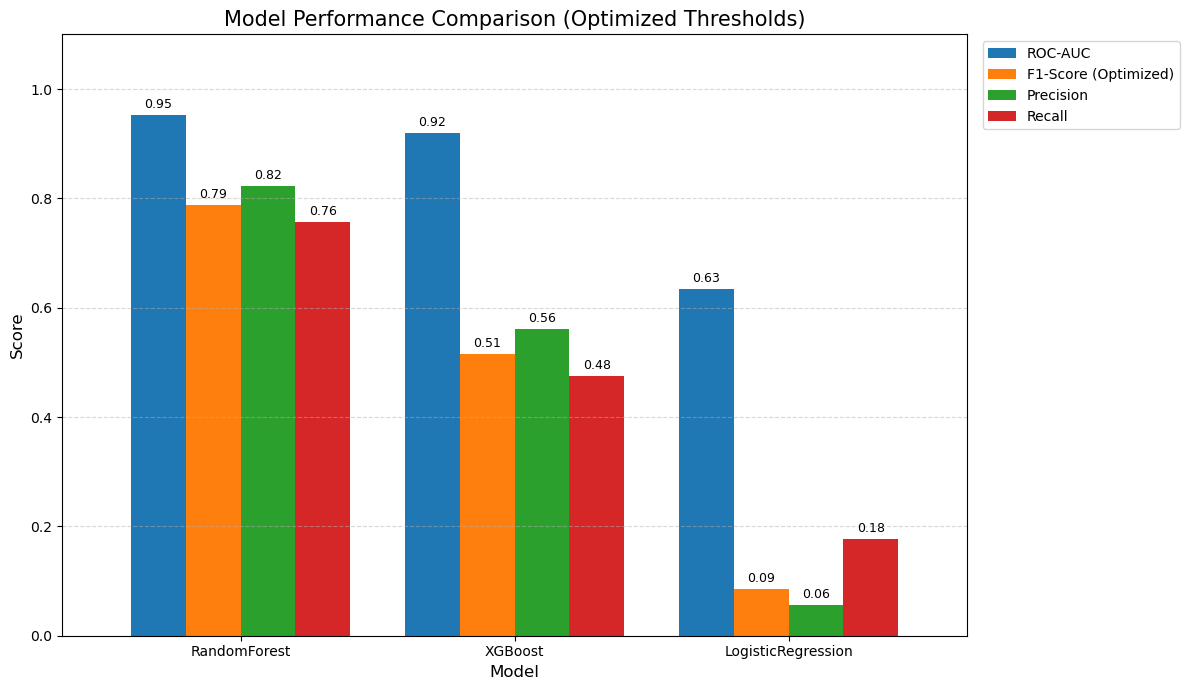

In [16]:
def plot_model_performance(results_df):
    """
    Plots model comparison based on the results DataFrame.
    """
    # Set 'model' as index for easy plotting
    if 'model' in results_df.columns:
        df_plot = results_df.set_index('model')
    else:
        df_plot = results_df.copy()

    # Metrics to plot (from our improved evaluation step)
    metrics = ['auc', 'best_f1', 'precision_at_best_f1', 'recall_at_best_f1']
    
    # Rename columns for cleaner legend
    rename_map = {
        'auc': 'ROC-AUC',
        'best_f1': 'F1-Score (Optimized)',
        'precision_at_best_f1': 'Precision',
        'recall_at_best_f1': 'Recall'
    }
    
    # Filter and rename
    df_plot = df_plot[metrics].rename(columns=rename_map)
    
    # Plotting
    ax = df_plot.plot(kind='bar', figsize=(12, 7), width=0.8)
    
    plt.title('Model Performance Comparison (Optimized Thresholds)', fontsize=15)
    plt.ylabel('Score', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0)
    plt.ylim(0, 1.1)  # Extra space for labels
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Add text labels on bars
    for p in ax.patches:
        # Ignore zero-height bars (if any)
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', 
                       fontsize=9, xytext=(0, 3), 
                       textcoords='offset points')
    
    plt.tight_layout()
    plt.show()

# Call the function directly with the results DataFrame
plot_model_performance(results_df)